20 % test 80 train

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.optimize import minimize
from sklearn.metrics import accuracy_score, f1_score
from functools import partial
from tqdm import tqdm

import torch
import torch.nn as nn

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
# from tensorflow.keras import layers
# from tensorflow.keras import layers
# from tensorflow.keras.preprocessing import image_dataset_from_directory
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Convolution2D
# from tensorflow.keras import utils
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import keras
from keras.utils import img_to_array, array_to_img, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')



In [7]:
# Преобразование картинок
import pathlib

dir_path = pathlib.Path.cwd()
dir_path = str(dir_path)
dir_path

'C:\\Users\\Интенсив\\Documents\\GIT\\Intensive'

In [8]:
data_path='ReadyMaterial/Drinks/Coffee/'
filenames = os.listdir(data_path)
print(filenames)

['Bad', 'Good']


In [9]:
classes = {"Bad": "0", "Good": "1"}
allFilenames = []
allCategories = []
for classElement in classes:
    filenames = os.listdir(data_path+classElement)
    allFilenames += [classElement + "/" + file for file in filenames]
    allCategories += [classes[classElement]] * len(filenames)


df = pd.DataFrame({
    'filename': allFilenames,
    'class': allCategories
})

In [10]:
# посмотрим на первые 10 строк
df.head(10)

filename class
0   Bad/1.jpg     0
1  Bad/10.jpg     0
2  Bad/11.jpg     0
3  Bad/12.jpg     0
4  Bad/13.jpg     0
5  Bad/14.jpg     0
6  Bad/15.jpg     0
7  Bad/16.jpg     0
8  Bad/17.jpg     0
9   Bad/2.jpg     0

In [11]:
# и на последние 10 строк
df.tail(10)

filename class
73  Good/60.jpg     1
74  Good/61.jpg     1
75  Good/62.jpg     1
76  Good/63.jpg     1
77  Good/64.jpg     1
78  Good/65.jpg     1
79  Good/66.jpg     1
80   Good/7.jpg     1
81   Good/8.jpg     1
82   Good/9.jpg     1

Text(0.5, 1.0, 'РАСПРЕДЕЛЕНИЕ ПО КЛАССАМ Coffee')

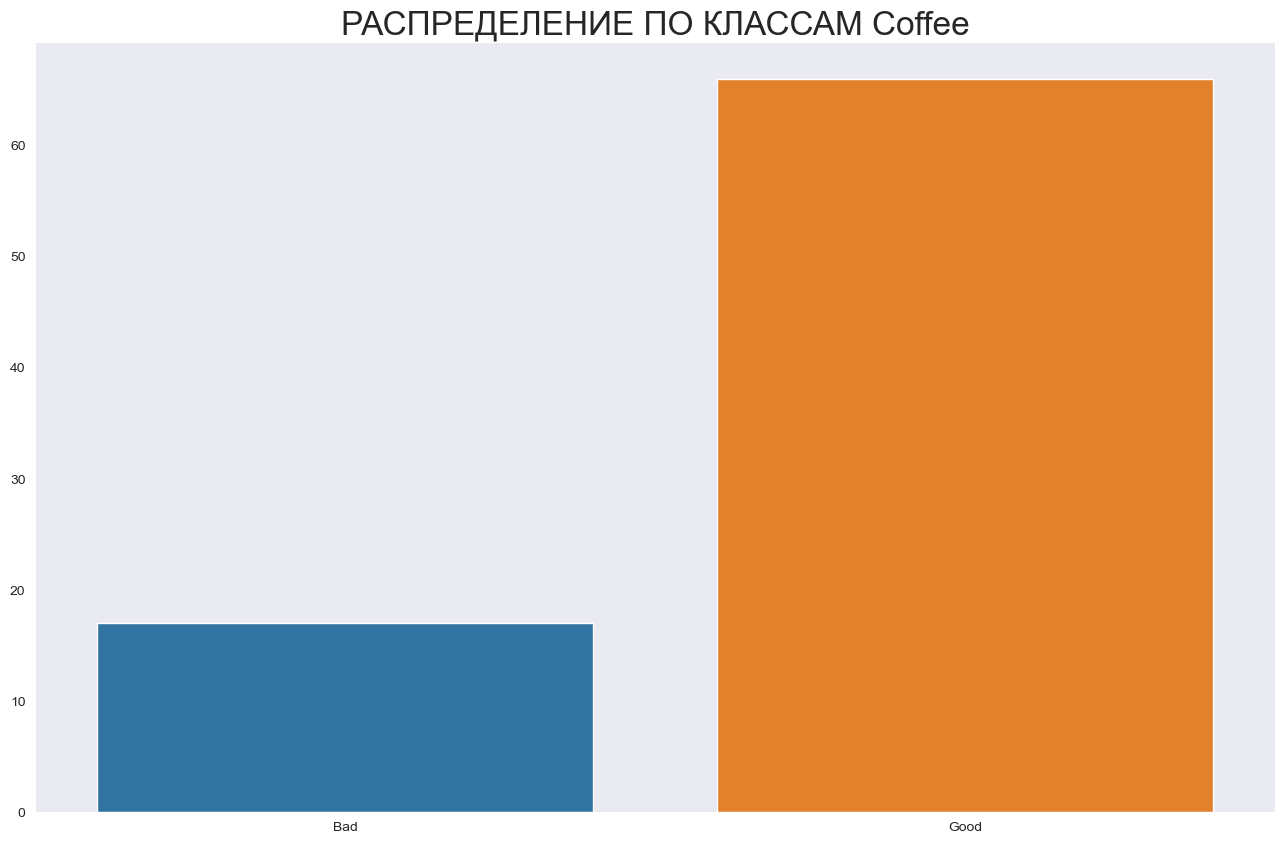

In [12]:
# Визуализация загруженных данных
class_names = ['Bad', 'Good']
y = [len(df[df["class"] == "0"]), len(df[df["class"] == "1"])]

sns.set_style('dark')
plt.figure(figsize=(16, 10))

sns.barplot(y=y, x=class_names).set_title("РАСПРЕДЕЛЕНИЕ ПО КЛАССАМ Coffee", fontsize = 24)


In [13]:
# разделение на тестовую и обучающую выборки (как было описано выше)
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df, test_size = 0.20)
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)

In [14]:
df_train

filename class
0   Good/46.jpg     1
1   Good/22.jpg     1
2   Good/19.jpg     1
3   Good/39.jpg     1
4     Bad/5.jpg     0
..          ...   ...
61  Good/12.jpg     1
62  Good/23.jpg     1
63    Bad/4.jpg     0
64   Bad/14.jpg     0
65  Good/51.jpg     1

[66 rows x 2 columns]

In [15]:
df_val

filename class
0    Bad/16.jpg     0
1    Good/3.jpg     1
2   Good/15.jpg     1
3   Good/43.jpg     1
4   Good/50.jpg     1
5   Good/57.jpg     1
6   Good/37.jpg     1
7   Good/25.jpg     1
8   Good/53.jpg     1
9   Good/36.jpg     1
10  Good/14.jpg     1
11   Bad/13.jpg     0
12  Good/52.jpg     1
13   Bad/11.jpg     0
14  Good/59.jpg     1
15  Good/58.jpg     1
16  Good/11.jpg     1

### Аугментация
Для аугментации увеличением данных используем ImageDataGenerator

In [16]:
train_datagen = ImageDataGenerator(
    rotation_range = 45,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    rescale = 1./255,
    fill_mode = 'reflect'
)

train_generator = train_datagen.flow_from_dataframe(
    df_train,
    data_path,
    x_col = 'filename',
    y_col = 'class',
    target_size = (150, 150),
    class_mode = 'categorical',
    batch_size = 64
)


Found 66 validated image filenames belonging to 2 classes.


In [17]:
df_example = df_train.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    df_example,
    data_path,
    x_col='filename',
    y_col='class',
    target_size = (150, 150),
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


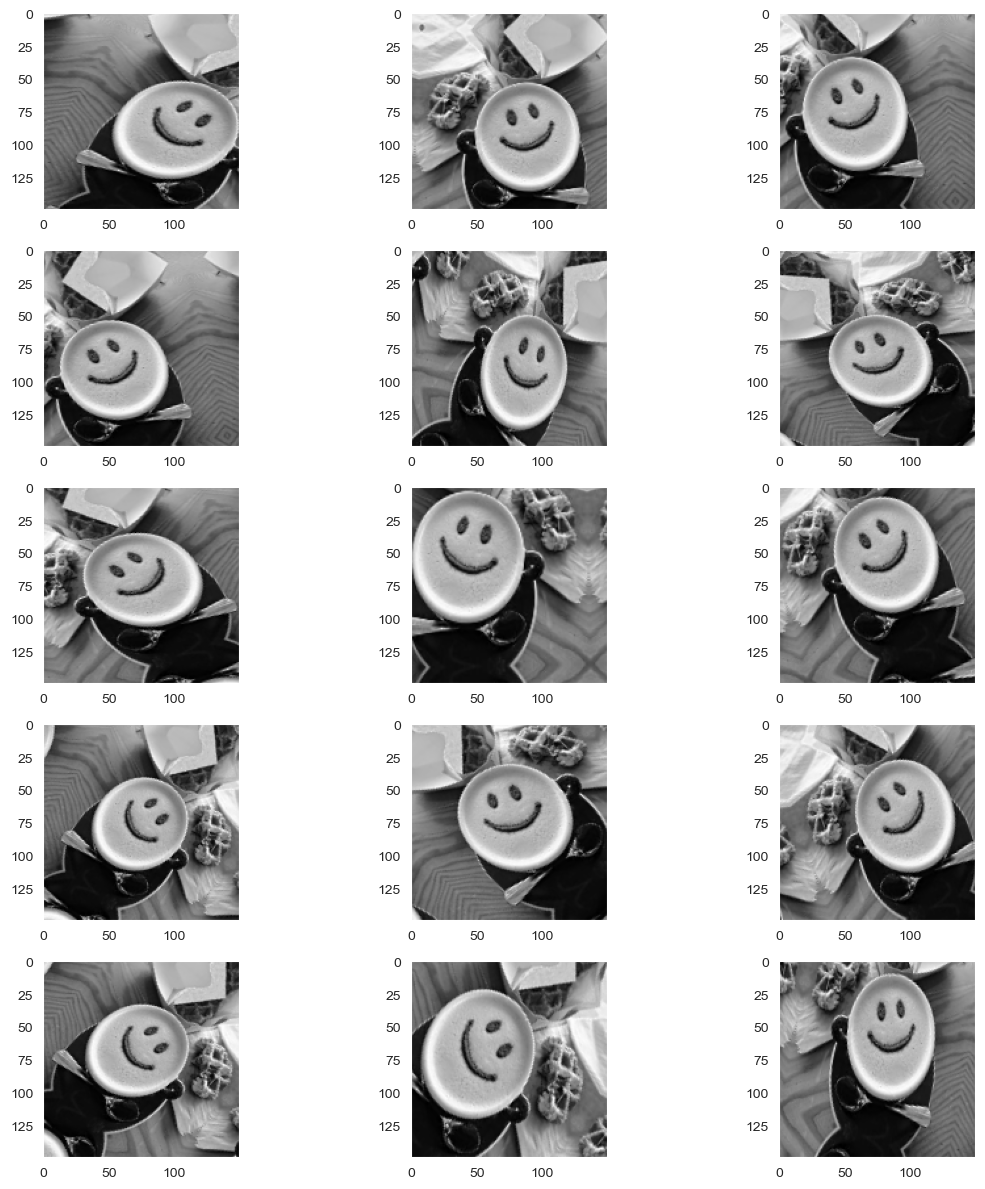

In [18]:
# Посмотрим на результат такой аугментации данных
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [19]:
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    df_val,
    data_path,
    x_col = 'filename',
    y_col = 'class',
    target_size = (150, 150),
    class_mode = 'categorical',
    batch_size = 64
)

Found 17 validated image filenames belonging to 2 classes.


## Создание модели

In [20]:
# Модель
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# компиляция модели многолассовой классификации
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 72, 72, 64)       2

Основной проблемой в обучении нейронных сетей является время их обучения.

Слишком короткое обучение будет означать, что модель будет соответствовать обучающему и тестовым наборам. Слишком долгое обучение будет означать, что модель будет соответствовать обучающему набору данных и будет иметь плохие характеристики на тестовом наборе.

Компромисс состоит в том, чтобы прекращать обучение в тот момент, когда производительность в проверочном наборе данных начинает ухудшаться.

Поэтому для оптимизации обучения модели мы и используем простой, эффективный и широко используемый подход к обучению нейронных сетей - раннюю остановку, а также снижение скорости обучения.


In [21]:
early_stopping = EarlyStopping(patience=10)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, factor = 0.5, min_lr = 0.00001)
callbacks = [early_stopping, reduce_lr]

In [22]:
!nvidia-smi

Wed Dec 14 18:40:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 26%   36C    P8     6W / 100W |     86MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
with tf.compat.v1.Session() as sess:
    devices = sess.list_devices()

In [24]:
with tf.device('/gpu:0'):
    history = model.fit_generator(
        train_generator,
        epochs = 10,
        validation_data = validation_generator,
        callbacks = callbacks
    )

Epoch 1/10
2/2 [==============================] - 4s 2s/step - loss: 1.5989 - accuracy: 0.4697 - val_loss: 1.7305 - val_accuracy: 0.8235 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 2s 2s/step - loss: 4.8119 - accuracy: 0.6061 - val_loss: 0.8174 - val_accuracy: 0.3529 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 2s 2s/step - loss: 1.5469 - accuracy: 0.5455 - val_loss: 0.5987 - val_accuracy: 0.8235 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 2s 2s/step - loss: 2.5637 - accuracy: 0.5909 - val_loss: 0.4995 - val_accuracy: 0.7647 - lr: 0.0010
Epoch 5/10
2/2 [==============================] - 2s 2s/step - loss: 1.1363 - accuracy: 0.6667 - val_loss: 0.6132 - val_accuracy: 0.8235 - lr: 5.0000e-04
Epoch 6/10
2/2 [==============================] - 2s 428ms/step - loss: 0.8791 - accuracy: 0.6667 - val_loss: 0.7286 - val_accuracy: 0.8235 - lr: 5.0000e-04
Epoch 7/10
2/2 [==============================] - 2s 418ms/step - loss: 0.7591 - accuracy


Наша модель невероятно долго обучается... Мне никак не удалось с этим справиться... Похоже, что gpu не работает, !nvidia-smi тоже не подключилось...

In [25]:
# Визуализируем результаты
fig = go.Figure()

fig.add_trace(go.Scatter(y = history.history['loss'],
                         mode='lines+markers',
                         name='Training loss'))
fig.add_trace(go.Scatter(y = history.history['val_loss'],
                         mode='lines+markers',
                         name='Validation loss'))

fig.update_layout(title_text = 'ОШИБКА МОДЕЛИ')
fig.show()

In [26]:
fig = go.Figure()

fig.add_trace(go.Scatter(y = history.history['accuracy'],
                         mode='lines+markers',
                         name='Training accuracy'))
fig.add_trace(go.Scatter(y = history.history['val_accuracy'],
                         mode='lines+markers',
                         name='Validation accuracy'))

fig.update_layout(title_text = 'ТОЧНОСТЬ МОДЕЛИ')
fig.show()

In [31]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("coffee_bad_good_model.h5")
print("Saved model to disk")

Saved model to disk


In [32]:
from keras.models import model_from_json
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("coffee_bad_good_model.h5")
print("Loaded model from disk")

Loaded model from disk


# Test

In [27]:
print(os.getcwd())

C:\Users\Интенсив\Documents\GIT\Intensive


In [28]:
test_data_path = 'TestMaterial/Drinks/Coffee/'
allFilenames_test = []
allCategories_test = []
for classElement in classes:
    filenames = os.listdir(test_data_path + classElement)
    allFilenames_test += [classElement + "/" + file for file in filenames]
    allCategories_test += [classes[classElement]] * len(filenames)


df_test = pd.DataFrame({
    'filename': allFilenames_test,
    'class': allCategories_test
})
df_test

FileNotFoundError: [WinError 3] Системе не удается найти указанный путь: 'TestMaterial/Drinks/Coffee/Bad'

In [29]:
test_generator = ImageDataGenerator(rescale = 1./255)
test_generator = test_generator.flow_from_dataframe(
    df_test,
    test_data_path,
    x_col='filename',
    y_col=None,
    class_mode= None,
    target_size = (150, 150),
    batch_size = 64,
    shuffle = False
)

NameError: name 'df_test' is not defined

In [ ]:
with tf.device('/gpu:0'):
    predict = model.predict_generator(test_generator, steps = np.ceil(df_test.shape[0] / 64))

In [ ]:
df_test['prediction'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
df_test['prediction'] = df_test['prediction'].replace(label_map)
df_test['prediction'] = df_test['prediction'].replace({ '1': 1, '0': 0 })